### Predict Student Performance from Game Play

The goal of this competition is to predict student performance during game-based learning in real-time.

This is the full convolution neural network baseline which gives good results on 1,2,3,9,12,17 and 18 questions.
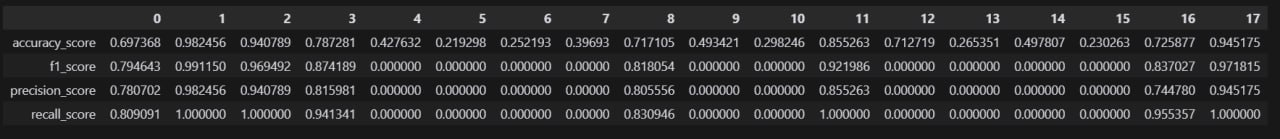
Abobe are result on the training on full train dataset on GPU during 8 hours.
In the code bellow just about 900 sessions sample is used. If you want to reproduce training results you should change the size of data in commented rows of code.

#### Note 1
On March 20 2023, Kaggle doubled the size of train data and you need more than 8 RAM to upload all train data in this notebook to run model on full dataset to reproduce our results. But worth to mention that I tested here with 20M rows (more than 2/3 of original dataset and it fits in 8Gb RAM). 

#### Note 2
Model in this notebook is just a simple model and shows that in a few questions obtain a good results is not too difficult. I also tried transformer model that gives significantly better scores.

Question: 1 F1: 0.843 Question: 2 F1: 0.989

Question: 3 F1: 0.966 Question: 4 F1: 0.890

Question: 5 F1: 0.720 Question: 6 F1: 0.874

Question: 7 F1: 0.848 Question: 8 F1: 0.760

Question: 9 F1: 0.850 Question: 10 F1: 0.615

Question: 11 F1: 0.784 Question: 12 F1: 0.926

Question: 13 F1: 0.375 Question: 14, F1: 0.84 

Question: 15, F1: 0.63 Question: 16 F1: 0.847

Question: 17 F1: 0.815 Question: 18 F1: 0.975

Average F1 is about 0.8

**If you find this notebook interesting please upvote, this motivates a lot to share the results! Thank you!**

In [1]:
import json
import pandas as pd
import numpy as np
from tqdm import tqdm, trange

In [2]:
from sklearn.preprocessing import normalize
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

In [3]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import Dataset, DataLoader

In [4]:
class Config:
    TRAIN_PATH = '../inputs/train.csv'
    TEST_PATH = '../inputs/test.csv'
    TRAIN_LABELS = '../inputs/train_labels.csv'
    SAMPLE_SUBMISSION = '../inputs/sample_submission.csv'

## Data preprocess

In [5]:
# To reproduce our results you will need to read full dataset. The original train size is 2.629.6946 rows.

data = pd.read_csv(Config.TRAIN_PATH, nrows = 5000000)

In [6]:
session_ids = list(np.unique(data["session_id"]))

In [7]:
len(session_ids) # First 1M rows contain near 900 unique sessions. 670 sessions would be for train and rest to test.

4433

In [8]:
rooms = list(np.unique(data["room_fqid"].astype(str)))
rooms_dict = {}
for i in range(len(rooms)):
    rooms_dict[rooms[i]] = i

In [9]:
every_action = list(np.unique(data["event_name"]))
def action_counter(data, action):
    return len(data[data["event_name"] == action])

In [10]:
def make_2d_array_for_session(data, rooms):
    res = {}
    for room in rooms:
        res[room] = []
        for action in every_action:
            if action == "checkpoint": continue
            room_data = data[data["room_fqid"] == room]
            res[room].append(action_counter(room_data, action))
            action_data = room_data[room_data["event_name"] == action]
            if "click" in action:
                if res[room][-1] == 1: 
                    res[room].append(list(action_data["room_coor_x"])[0])
                    res[room].append(list(action_data["room_coor_y"])[0])
                elif res[room][-1] > 1:
                    res[room].append(np.mean(action_data["room_coor_x"]))
                    res[room].append(np.mean(action_data["room_coor_y"]))
                elif res[room][-1] == 0:
                    res[room].append(0)
                    res[room].append(0)
            if "hover" in action:
                if res[room][-1] == 0: res[room].append(0)
                else:
                    res[room].append(np.mean(list(action_data["hover_duration"])))
            try:
                res[room].append(np.min(list(room_data["level"])))
                res[room].append(max(list(room_data["level"])))
            except:
                res[room].append(0)
                res[room].append(0)
    res = pd.DataFrame(res)
    res = np.array(res)
    res = normalize(res, axis=1, norm='l2')
    return res

In [11]:
process_data = {}
for id in tqdm(session_ids): # for relize delete this index
    session = data[data["session_id"] == id]
    if len(session[session["event_name"] == "checkpoint"]) != 3: continue
    process_data[id] = make_2d_array_for_session(data[data["session_id"] == id], rooms)
    if process_data[id].shape != (48, 19): print(f"WARNING id {id} has wrong shape")

100%|████████████████████████████████████████████████████████████████████████████████| 4433/4433 [08:17<00:00,  8.90it/s]


In [13]:
data = {}
data = {int(key): value for key, value in process_data.items()}

for key in data:
    data[key] = data[key].tolist()

In [14]:
data_sessions = list(data)

In [15]:
len(session_ids)

4433

## Target preprocess 

In [16]:
labels = pd.read_csv(Config.TRAIN_LABELS)

In [17]:
labels_ids = list(labels["session_id"])
corrects = list(labels["correct"])

In [18]:
res = {}
res["session_id"] = []
res["question"]= []
res["label"] = []
for i, session_id in enumerate(labels_ids):
    if int(session_id.split("_")[0]) in data_sessions:
        res["session_id"].append(int(session_id.split("_")[0]))
        res["question"].append(session_id.split("_")[1][1:])
        res["label"].append(int(corrects[i]))

In [19]:
processed_labels = pd.DataFrame(res)
processed_labels

,session_id,question,label
0,20090312431273200,1,1
1,20090312433251036,1,0
2,20090312455206810,1,1
3,20090313091715820,1,0
4,20090313571836404,1,1
...,...,...,...
79177,21000412185488852,18,1
79178,21000412191502590,18,1
79179,21000412191687670,18,1
79180,21000412202661730,18,1


## Training

### Define all stuff

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
device

device(type='cuda')

In [22]:
def return_labels_for_id(labels: pd.DataFrame, id: int):
    return list(labels[labels["session_id"] == id]["label"])

In [23]:
class MyDataset(Dataset):
    def __init__(self, data, labels):
        if len(data) != len(labels):
            raise ValueError("Not matching in lens data and labels")
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [24]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, output_size):
        super(NeuralNet, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(input_size, input_size*8)
        self.fc2 = nn.Linear(input_size*8, input_size*2)
        #self.dropout = nn.Dropout(p=0.1)
        self.fc3 = nn.Linear(input_size*2, output_size)

    def forward(self, x):
        out = x.view(912)
        out = torch.nn.functional.relu(self.fc1(out))
        #out = self.dropout(out)
        out = torch.nn.functional.relu(self.fc2(out))
        out = torch.nn.functional.relu(self.fc3(out))
        return out

### Load data in dataloader

In [25]:
train_labels = np.array([np.array(return_labels_for_id(processed_labels, int(id))) for id in list(data)[:4000]]) # Here you point size of train
train_data = list(data.items())[:4000] # Here the same

train_array_data = []
train_array_labels = []
for i, arr in enumerate(train_data):
    train_array_labels.append(np.array(train_labels[i]))
    train_array_data.append(np.array(arr[1]))

train_data = np.array(train_array_data)
train_data = torch.Tensor(train_data.astype(np.float64))
train_labels = np.array(train_array_labels).astype(np.float64)

In [26]:
dataset = MyDataset(train_data, train_labels)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

In [27]:
train_data.shape

torch.Size([4000, 48, 19])

### Define model

In [28]:
input_size = train_data.shape[1] * train_data.shape[2] #912
output_size = 18

model = NeuralNet(input_size, output_size)
model.to(device)

lr = 0.01
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.AdamW(model.parameters(), lr=lr)

### Fit

In [29]:
for epoch in trange(10): # Change value
    avg_loss = 0.0
    for batch_idx, (data, target) in (enumerate(dataloader)):
        optimizer.zero_grad()
        loss = 0.0
        for p in range(len(data)):
            output = model(data[p].to(device))
            output = output.cpu()
            loss += criterion(output, target[p])
        loss.backward()
        optimizer.step()
        avg_loss += loss.item()
    print('Epoch %d loss: %.3f' % (epoch + 1, avg_loss/len(data)))

 10%|████████▌                                                                            | 1/10 [00:16<02:27, 16.41s/it]

Epoch 1 loss: 157.202


 20%|█████████████████                                                                    | 2/10 [00:22<01:25, 10.63s/it]

Epoch 2 loss: 76.863


 30%|█████████████████████████▌                                                           | 3/10 [00:29<01:01,  8.75s/it]

Epoch 3 loss: 76.888


 40%|██████████████████████████████████                                                   | 4/10 [00:36<00:47,  7.88s/it]

Epoch 4 loss: 76.898


 50%|██████████████████████████████████████████▌                                          | 5/10 [00:42<00:36,  7.39s/it]

Epoch 5 loss: 76.815


 60%|███████████████████████████████████████████████████                                  | 6/10 [00:49<00:28,  7.08s/it]

Epoch 6 loss: 76.721


 70%|███████████████████████████████████████████████████████████▍                         | 7/10 [00:55<00:20,  6.92s/it]

Epoch 7 loss: 76.708


 80%|████████████████████████████████████████████████████████████████████                 | 8/10 [01:02<00:13,  6.80s/it]

Epoch 8 loss: 76.632


 90%|████████████████████████████████████████████████████████████████████████████▌        | 9/10 [01:08<00:06,  6.71s/it]

Epoch 9 loss: 76.636


100%|████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:15<00:00,  7.52s/it]

Epoch 10 loss: 76.759


### Test model

In [30]:
data = {}
data = {int(key): value for key, value in process_data.items()}

for key in data:
    data[key] = data[key].tolist()

In [31]:
test_labels.shape

NameError: name 'test_labels' is not defined

In [ ]:
train_labels.shape

In [ ]:
test_labels = np.array([np.array(return_labels_for_id(processed_labels, int(id))) for id in list(data)[4000:]]) # Here you point size of train
test_data = list(data.items())[4000:] # Here the same

test_array_data = []
test_array_labels = []
for i, arr in enumerate(test_data):
    test_array_labels.append(np.array(test_labels[i]))
    test_array_data.append(np.array(arr[1]))

test_data = np.array(test_array_data)
test_data = torch.Tensor(test_data.astype(np.float64))
test_labels = np.array(test_array_labels).astype(np.float64)

dataset = MyDataset(test_data, test_labels)
dataloader = DataLoader(dataset, batch_size=16, shuffle=False)

In [ ]:
predict = []

targets = []
for batch_idx, (data_chunk, target) in tqdm((enumerate(dataloader))):
    for p in range(len(data_chunk)):
        predict.append(model(data_chunk[p].to(device)).cpu())
        targets.append(target[p])

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
def print_metrics(target, predict):
    res = {}
    res["accuracy_score"] = []
    res["f1_score"] = []
    res["precision_score"] = []
    res["recall_score"] = []
    predict = np.array([x.detach().numpy() for x in predict])
    target = np.array([x.detach().numpy() for x in target])
    for i in range(18):
        i_target = target[:, i]
        i_predict = predict[:, i].copy()
        for j in range(len(i_predict)):
            if i_predict[j] > 0.4: i_predict[j] = 1.0
            else: i_predict[j] = 0.0
        res["accuracy_score"].append(accuracy_score(i_target, i_predict))
        res["precision_score"].append(precision_score(i_target, i_predict))
        res["recall_score"].append(recall_score(i_target, i_predict))
        res["f1_score"].append(f1_score(i_target, i_predict, average='macro'))
    print(predict)
    print(f"f1_score for all data: {f1_score(target.flatten(), predict.flatten()>0.4, average='macro')}")
    scores = []; thresholds = []
    best_score_xgb = 0; best_threshold_xgb = 0

    for threshold in np.arange(0.4,0.81,0.005):
        print(f'{threshold:.03f}, ',end='')
        preds = ( predict.flatten()>threshold).astype('int')
        m = f1_score(target.flatten(),preds, average='macro')  
        scores.append(m)
        thresholds.append(threshold)
        if m>best_score_xgb:
            best_score_xgb = m
            best_threshold_xgb = threshold

    # PLOT THRESHOLD VS. F1_SCORE
    plt.figure(figsize=(20,5))
    plt.plot(thresholds,scores,'-o',color='blue')
    plt.scatter([best_threshold_xgb], [best_score_xgb], color='blue', s=300, alpha=1)
    plt.xlabel('Threshold',size=14)
    plt.ylabel('Validation F1 Score',size=14)
    plt.title(f'Threshold vs. F1_Score with Best F1_Score = {best_score_xgb:.5f} at Best Threshold = {best_threshold_xgb:.4}',size=18)
    plt.show()
    return res

In [ ]:
res = print_metrics(targets, predict)

In [183]:
res

{'accuracy_score': [0.3383458646616541,
  0.9899749373433584,
  0.9373433583959899,
  0.20551378446115287,
  0.48621553884711777,
  0.22305764411027568,
  0.2531328320802005,
  0.42857142857142855,
  0.2731829573934837,
  0.49122807017543857,
  0.3258145363408521,
  0.15037593984962405,
  0.6942355889724311,
  0.3383458646616541,
  0.5338345864661654,
  0.2581453634085213,
  0.3258145363408521,
  0.9448621553884712],
 'f1_score': [0.2528089887640449,
  0.49748110831234255,
  0.4838292367399741,
  0.1704781704781705,
  0.3271500843170321,
  0.18237704918032788,
  0.202,
  0.3,
  0.21456692913385828,
  0.32941176470588235,
  0.2457466918714556,
  0.13071895424836602,
  0.40976331360946744,
  0.2528089887640449,
  0.3480392156862745,
  0.20517928286852588,
  0.2457466918714556,
  0.4858247422680413],
 'precision_score': [0.0,
  0.9899749373433584,
  0.9373433583959899,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.0,
  0.9448621553884712],


In [42]:
predict[0]

tensor([0.0000, 7.3576, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
       grad_fn=<ToCopyBackward0>)